## Commodity Price Analysis

This part of the project will focus on analysing commodity prices following the start of the genocide in Gaza.

The commodity_price_change_from_baseline mart is used for analysis, which is based on the following data: https://data.humdata.org/dataset/state-of-palestine-price-of-basic-commodities-in-gaza

The baseline price column is the commodity price before the start of the genocide, and all other listed prices are during the genocide. All percentage changes are measured relative to the baseline price.

### Hypothesis

Periods of intensified hostilities are expected to coincide with higher average commodity prices - driven by reduced availablity of humanitarian aid, restrictions on movement and disruptions to supply chains.

Conversely, this could mean that commodity prices are relatively lower during ceasefires, which occurred during the following dates:
- 24th November 2023 to 11th January 2024
- 19th January 2025 to 17th March 2025
- 3rd October 2025 to present

With regards to specific items, it is expected that prices will generally increase over time relative to the pre-October 2023 baseline, reflecting sustained supply constraints. The magnitude of price increases are expected to vary by commodity. 

Staple items such as basic cooking ingredients and food are likely to be prioritised in humanitarian aid, and due to humanitarian aid being a key supply of commodities - it is expected that these types of items may exibit smaller relative increases. On the other hand, items less commonly included in aid shipments may experience larger spikes in price. However, if several essential commodities become extremely sparce then it's possible that they could see huge increases in price together.

In [4]:
import duckdb
import pandas as pd
from matplotlib import pyplot as plt
from adjustText import adjust_text
from IPython.display import display, display_html

con = duckdb.connect("../dev.duckdb")

### Average commodity prices by month

First, lets see which five months had the highest average commodity prices and which five months had the lowest average commodity prices.

In [6]:
top5 = con.execute("""
    SELECT
        STRFTIME(price_date, '%b-%Y') AS date,
        ROUND(AVG(price), 2) AS avg_price
    FROM main_mart.fct_commodity_prices_gaza
    GROUP BY price_date
    ORDER BY avg_price DESC
    LIMIT 5
""").df()

bottom5 = con.execute("""
    SELECT
        STRFTIME(price_date, '%b-%Y') AS date,
        ROUND(AVG(price), 2) AS avg_price
    FROM main_mart.fct_commodity_prices_gaza
    GROUP BY price_date
    ORDER BY avg_price ASC
    LIMIT 5
""").df()

html = f"""
<div style="display: flex; gap: 40px;">
  <div>
    <h4>Highest average prices</h4>
    {top5.to_html(index=False)}
  </div>
  <div>
    <h4>Lowest average prices</h4>
    {bottom5.to_html(index=False)}
  </div>
</div>
"""
display_html(html, raw=True)
###

date,avg_price
Jul-2025,424.56
May-2025,360.79
Jun-2025,360.30
Aug-2025,247.80
Dec-2024,210.03
date,avg_price
Oct-2023,15.54
Nov-2023,36.75
Feb-2025,48.76
Dec-2025,49.51


The highest average prices seem to be mostly concentrated in the May 2025 to August 2025 period, which suggests that commodities were particularly sparce during these consecutive months. The other date in the top 5 is December 2024, which could be due to it being 11 months after the previous ceasefire.

The lowest average prices generally happened at the right at the beginning of the genocide, in October 2023 to January 2024. There also was a ceasefire between the end of November until early January. The other date in the top 5, February 2025 was also during a ceasefire.

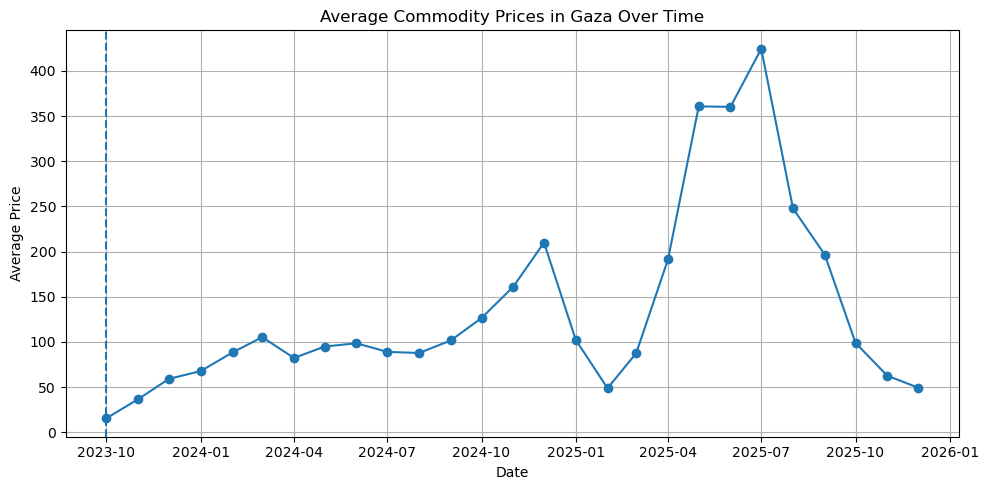

In [8]:
df = con.execute("""
    SELECT
        price_date,
        AVG(price) AS avg_price
    FROM main_mart.fct_commodity_prices_gaza
    GROUP BY price_date
    ORDER BY price_date
""").df()

plt.figure(figsize=(10, 5))
plt.plot(df["price_date"], df["avg_price"], marker='o')
plt.axvline(pd.to_datetime("2023-10-01"), linestyle="--")
plt.title("Average Commodity Prices in Gaza Over Time")
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.grid(True)
plt.tight_layout()
plt.show()

By visualising the average commodity prices over time, it can be seen that prices generally climbed when there were no active ceasefires. The drops in January 2025 can likely be attributed to the ceasefire at that time. Meanwhile the drop in August 2025 appears to be before the ceasefire which began in October. It is plausable that there was increased aid avaiable prior to the ceasefire. 

There was a slight reduction in prices around April 2024, meanwhile prices seemed to spike strongly either side of the January 2025 to March 2025 ceasefire. This change seems far too big to be due to short term volitility, and suggests that something else may have changed - such as additional aid restrictions, weather/explosives effecting agriculture or destruction of infrastructure. Analysing aid distribution should help in understanding why these happened, and will be investigated in the next notebook.

### Individual commodity prices by month

In this section, individual commodities will be investigated and compared. 

In the following table, the top 10 commodites with the highest percentage change from the baseline price are listed along with the date that this happened.

In [11]:
con.execute("""
    WITH max_unique AS (
    SELECT *,
        ROW_NUMBER() OVER (PARTITION BY commodity_name, unit_amount ORDER BY pct_change_from_baseline DESC) AS rn
    FROM main_mart.commodity_price_change_from_baseline
    )

    SELECT
        commodity_name,
        unit_amount,
        ROUND(price, 2) AS price,
        baseline_price,
        month_name || ' ' || year AS date,
        pct_change_from_baseline
    FROM max_unique
    WHERE rn = 1
    ORDER BY pct_change_from_baseline DESC
""").df().head(15)

,commodity_name,unit_amount,price,baseline_price,date,pct_change_from_baseline
0,pure white sugar,10 kg,3072.86,35.60,July 2025,8531.62
1,marlboro cigarettes,20 pack,1933.33,24.72,December 2024,7720.93
2,chili pepper,1 kg,291.25,3.75,September 2024,7666.67
3,dry onions,1 kg,240.36,3.63,June 2025,6521.40
4,l-m cigarettes,20 pack,1350.00,21.69,December 2024,6124.07
5,gas cylinder,12 kg,4200.00,71.25,September 2025,5794.74
6,gasoline,1 L,380.00,6.79,August 2025,5496.47
7,eggs,2 kg,600.00,13.33,October 2025,4401.13
8,cucumbers,1 kg,68.63,1.56,July 2025,4299.42
9,lemons,1 kg,90.00,2.56,June 2025,3415.63


One thing that can be seen from this table is that almost all the items on the list saw their highest ever prices between May 2025 and September 2025. The notable exceptions are the two types of cigarettes which both saw their highest ever price in December 2024.

Since the vast majority of the items saw their highest prices roughly around the same time, plotting a graph of each commodity's maximum percentage increase from the baseline price should help visualise how much the price of each commodity increased by as a percentage.  

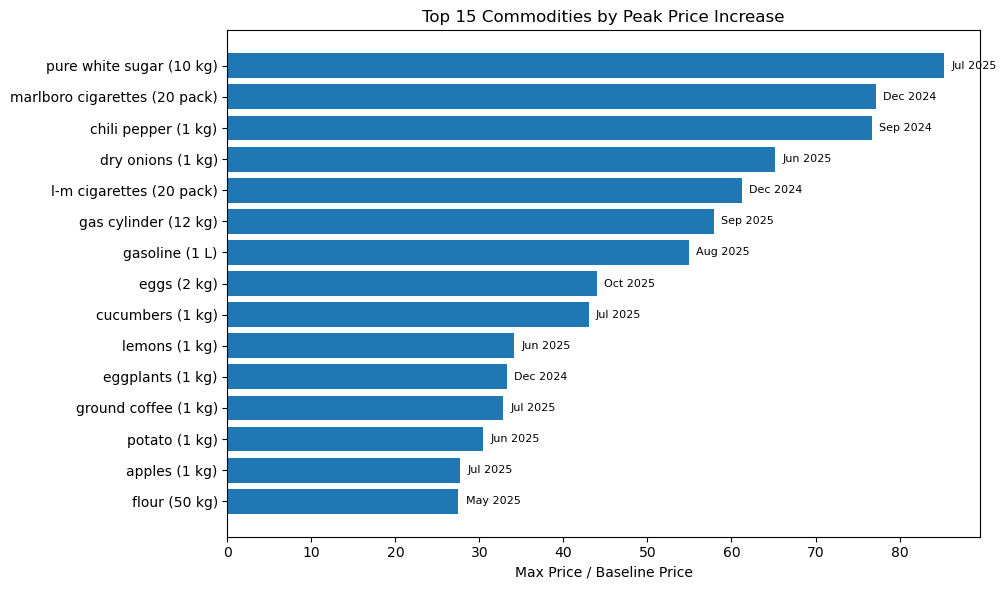

In [13]:
df = con.execute("""
    WITH ranked AS
    (
    SELECT
        commodity_name,
        unit_amount,
        baseline_price,
        price,
        pct_change_from_baseline / 100 AS price_divide_baseline,
        date,
        ROW_NUMBER() OVER (PARTITION BY commodity_name, unit_amount ORDER BY pct_change_from_baseline DESC) AS rn
    FROM main_mart.commodity_price_change_from_baseline
    )

    SELECT
        commodity_name,
        unit_amount,
        baseline_price,
        price AS max_price,
        price_divide_baseline AS max_price_divide_baseline,
        date AS max_price_date
    FROM ranked
    WHERE rn = 1
    ORDER BY price_divide_baseline DESC
    LIMIT 15
""").df()

plt.figure(figsize=(10, 6))
plt.barh(df["commodity_name"] + " (" + df["unit_amount"] + ")", df["max_price_divide_baseline"])
plt.gca().invert_yaxis()
plt.title("Top 15 Commodities by Peak Price Increase")
plt.xlabel("Max Price / Baseline Price")
plt.tight_layout()

offset = df["max_price_divide_baseline"].max() * 0.01
for i, value in enumerate(df["max_price_date"]):
    plt.text(df["max_price_divide_baseline"].iloc[i] + offset, i, value.strftime("%b %Y"), va="center", fontsize=8)

plt.show()

It seems that basic cooking ingredients and staple items are relatively grouped together, and most of them saw their highest prices in the May 2025 to October 2025 period. The notable exceptions are sugar and flour - and while their highest prices were around the same time period as the others, the magnitude of their price increases were significantly higher. One possible explanation is their longer shelf life, allowing them to be bought in bulk and stockpiled which would reduce market availablity.

The next graph helps visualise the relationship between each commodity's baseline price and its peak price.

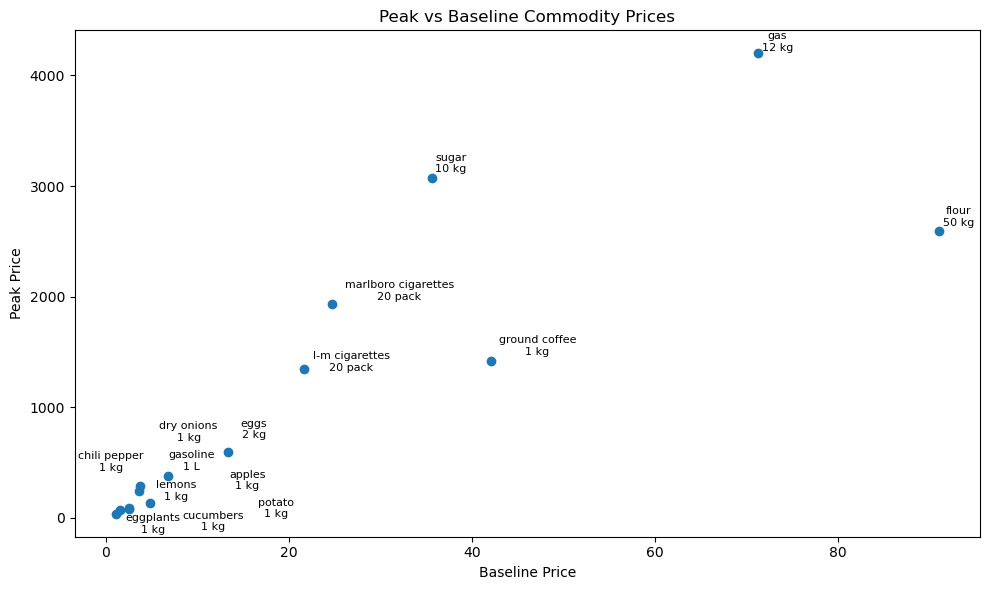

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(df["baseline_price"], df["max_price"])

df['scatter_labels'] = (
    df['commodity_name']
    .str.replace("pure white ", "")
    .str.replace(" cylinder", "")
    .str.replace(" distributed using tankers", "")
    + "\n" + df['unit_amount']
    .str.replace("liters", "L")
)

texts = []
for i in range(len(df)):
    texts.append(
    plt.text(
        df["baseline_price"].iloc[i],
        df["max_price"].iloc[i],
        df['scatter_labels'].iloc[i],
        fontsize=8
    ))

adjust_text(
    texts,
    force_text=(0.1, 0.1),
    force_points=(0.1, 0.1),
    expand_text=(1.05, 1.1),
    expand_points=(1.05, 1.1)
)

plt.xlabel("Baseline Price")
plt.ylabel("Peak Price")
plt.title("Peak vs Baseline Commodity Prices")
plt.tight_layout()
plt.show()

As seen from both the graphs, many staple food items exibit broadly similar percentage price increases. However, a number of commodities are outliers to this trend. Flour, sugar and gas cylinders experienced significantly larger relative increases than other essential goods, despite peaking at a similar time period. The baseline price does not seem to have any particular impact on what the maximum percentage peak price would be. Instead, the outliers share characteristics such as very large unit sizes and long shelf lives which may amplify scarcity effects and enable stockpiling. Conversely perishable food items in smaller purchasing units appear to exhibit more bounded price escalation, even during periods of heightened disruption.

### Conclusion

This analysis shows that average commodity prices in Gaza generally increased, with noticable price relief during ceasefire windows. Prices also seemed to fall slightly prior to the official beginning of the ceasefires - most clearly before the 3rd October 2025 ceasefire. This supports the hypothesis that heighten hostilities and restricted access place upward pressure on commodity prices, while ceasefires provide a temporary easing.

The scale of prices changes, multiples of hundreds or thousands from the baseline prices, suggests that long term structural factors were also at play. The prices spiked sharply at the end of 2024 and even more so in the middle of 2025, indicating disruptions to supply chains, infrastructure damage, and constraints on aid..

At the commodity level, most staple cooking items experienced broadly similar price trends, but flour and sugar showed disproportionally large increases relative to their baseline prices. Despite being staple goods, their long shelf life may have enabled stockpiling, thus reducing market availablity and amplifying price inflation compared to more perishable items.

In all, the findings suggest that conflict intensity and commodity specific characteristics had significant effect on price dynamics, motivating further analysis of prices along with aid distribution data in the next stage of this project.